In [1]:
from gurobipy import *
import pandas as pd
import numpy as np
import math

In [2]:
a=pd.read_excel('顺丰物流信息完整.xlsx',sheet_name=['运输业务量','城市间距离','运输时间','固定成本'])
df_goods=a['运输业务量']
df_distance=a['城市间距离']
df_time=a['运输时间']
df_fxcost=a['固定成本']

city_list=df_goods.columns.tolist()
distance={}
for city1 in city_list:
    for city2 in city_list:
        distance[city1,city2]=df_distance.loc[city1,city2]
distance=tupledict(distance)
#distance储存了所有城市之间的距离

times={}
for city1 in city_list:
    for city2 in city_list:
        times[city1,city2]=df_time.loc[city1,city2]
#times储存了所有城市之间的运输时间

goods={}
for city1 in city_list:
    for city2 in city_list:
        goods[city1,city2]=df_goods.loc[city1,city2]     
city_s,goods=multidict(goods)
#goods储存a城市运到b城市的货物数量
#city_s储存所有城市之间两两组合名

if_goods={}
for i,j in city_s:
    if goods[i,j]>0:
        if_goods[i,j]=1
    else:
        if_goods[i,j]=0
#if_goods储存了各个城市之间有没有航空运输需求

center_for_select=city_list
#四个被选出来的枢纽城市的候选
center_for_select=['北京','杭州','成都','深圳']
select_comb=[]
for city1 in center_for_select:
    for city2 in center_for_select:
        select_comb.append((city1,city2))
#枢纽城市两两组合

plane,plane_price,plane_load=multidict({'B737':[40000,14000],'B757':[70000,28000],'A300':[80000,40000]})
#plane：飞机的变动成本
#plane_price: 飞机每小时成本
#plane_load: 飞机载重
fix_cost={}
for plane_name in plane:
    for city_name in city_list:
        fix_cost[plane_name,city_name]=df_fxcost.loc[city_name,plane_name]
#fix_cost: 不同机型从不同机场起飞的固定成本
C=4.5 #散航运费
CN=4 #枢纽数量

## 建立模型：
$$
\begin{alignat}{2}
\min\quad & f=f_1+f_2&{}& \\
\mbox{s.t.}\quad
&(1)\quad f_1=\sum_{k}\sum_{m}\sum_{i}\sum_{j}[C_{ik}D_{ik}+C_{mj}D_{mj}]Z_{km}^{ij}W_{ij}\\
&(2)\quad f_2=\sum_{k}\sum_{m}\sum_{N}B_{km}^N(T_{km}P_N+F_k^N)\\
&(3)\quad \sum_{i}\sum_{j}W_{ij}Z_{km}^{ij}\leq \sum_{N}F_{km}^N Q_N\\
&(4)\quad F_{kk}^N=0,&\quad&\forall k \in\{枢纽\} \forall N\in\{飞机\}\\
&(5)\quad \sum_{k}\sum_{m}Z_{km}^{ij}=I_{ij} ,&\quad&\forall i,j\in\{机场\}\\
&(6)\quad 0\leq Z_{km}^{ij} \leq Y_k,&\quad&\forall i,j\in \{机场\}，k\in\{枢纽\}\\
&(7)\quad 0\leq Z_{km}^{ij} \leq Y_m,&\quad&\forall i,j\in \{机场\}，k\in\{枢纽\}\\
&(8)\quad \sum_{k} Y_k=CN\\
&(9)\quad M\times m_{ik}\geq \sum_{j}\sum_{m} Z_{km}^{ij}\\
&(10)\quad \sum_k m_{ik}=1,&\quad&\forall i \in\{机场\}
\end{alignat}
$$

$Z_{km}^{ij}​$: 0-1变量，从i到j的货物是否经过k,m枢纽，目标变量

$B_{km}^N$: 整数变量，从k到m使用N飞机的数量，目标变量

$F_k^N$:N类飞机从k机场起飞的固定成本

$Y_k$: 0-1变量，机场k是否为枢纽机场，目标变量

$m_{ik}$: 0-1变量，k是否为i机场的枢纽，目标变量

$C_{ab}$: a到b散航运输成本 元/kg·km， 这里全部记为4.5元/吨·km。

$Q_N$: N飞机的载重

$W_{ij}$: i到j的运输量

$I_{ij}$: 0-1变量，i到j是否有货物需要运输

$T_{km}$: k到m的飞行时间

$P_N$: N飞机单小时成本（按一天飞6小时算）

$CN$:  枢纽的数量

$M$: 大M值

我们的模型有如下假定：

1. 从普通机场到枢纽机场采用客机腹仓运输，且运力充足
2. 枢纽机场之间全部采用全货机直航，全货机可以租赁，且使用成本与自有货机一致，假定所有货机每天的运行时间是6小时

模型约束：

1. $f_1$表示普通机场到枢纽机场的运输成本总和，

2. $f_2$表示枢纽机场之间运输成本

3. 货物汇集到枢纽机场后发往另一枢纽机场，使用的飞机的总载重必须大于等于需要运输的货物重量；

4. 枢纽自己到自己的飞机数量为0

5. 每个普通机场只对应一个枢纽机场，若$i,j$两个机场之间没有运输任务，那么$Z_{km}^{ij}$必等于0；

6. 当k机场不是枢纽机场时，$Z_{km}^{ij}$必等于0；

7. 同6

8. 总的枢纽数量等于$CN$。

9. 当k是i的枢纽时，$m_{ik}$为1

10. 每个机场只有一个枢纽

In [3]:
m=Model('运输网络')
Z=m.addVars(city_s,select_comb,vtype=GRB.BINARY,name='Z')
F=m.addVars(plane,select_comb,vtype=GRB.INTEGER,name='F')
Y=m.addVars(center_for_select,vtype=GRB.BINARY,name='Y')
M=m.addVars(city_list,center_for_select,vtype=GRB.BINARY,name='M')

f1=0
for city1,city2 in city_s:
    for comb1,comb2 in select_comb:
        f1=f1+goods[city1,city2]*Z[city1,city2,comb1,comb2]*(0.001*C*distance[city1,comb1]+0.001*C*distance[comb2,city2])
f2=0
for comb1,comb2 in select_comb:
    for plane_name in plane:
        f2=f2+F[plane_name,comb1,comb2]*(times[comb1,comb2]*plane_price[plane_name]+fix_cost[plane_name,comb1])
#m.setObjective(f1+f2,GRB.MINIMIZE)


for comb1,comb2 in select_comb:
    m.addConstr(quicksum(goods[i,j]*Z[i,j,comb1,comb2] for i,j in city_s)<=
                quicksum(F[plane_name,comb1,comb2]*plane_load[plane_name] for plane_name in plane))
HZOUT=0
for comb in center_for_select:
    HZOUT+=quicksum(goods[i,j]*Z[i,j,'杭州',comb] for i,j in city_s)
m.addConstr(HZOUT<=400000)
SZIN=0
for comb in center_for_select:
    SZIN+=quicksum(goods[i,j]*Z[i,j,comb,'深圳'] for i,j in city_s)
m.addConstr(SZIN<=500000)
for comb in center_for_select:
    for plane_name in plane:
        m.addConstr(F[plane_name,comb,comb]==0)
for city1,city2 in city_s:
    m.addConstr(Z.sum(city1,city2,'*','*')==if_goods[city1,city2])
for city1,city2 in city_s:
    for comb1,comb2 in select_comb:
        m.addConstr(Z[city1,city2,comb1,comb2]<=Y[comb1])
for city1,city2 in city_s:
    for comb1,comb2 in select_comb:
        m.addConstr(Z[city1,city2,comb1,comb2]<=Y[comb2])
m.addConstr(Y.sum('*')==CN)
for city in city_list:
    for comb in center_for_select:
        m.addConstr(1000*M[city,comb]>=Z.sum(city,'*',comb,'*'))
for city in city_list:
    m.addConstr(M.sum(city,'*')==1)
m.addConstr(M['重庆','成都']==1)
    

m.optimize()

Optimize a model with 9654 rows, 4744 columns and 33993 nonzeros
Variable types: 0 continuous, 4744 integer (4696 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+04]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+05]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.03 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


In [4]:
df=pd.DataFrame(m.getAttr('x',Y),index=['Yk']).T.astype(int)
centers=df[df['Yk']==1].index.tolist()
centers

['北京', '成都', '杭州', '深圳']

In [5]:
df2=pd.DataFrame(index=[item for item in city_list if item not in centers],columns=centers)
for city1 in [item for item in city_list if item not in centers]:
    for city2 in centers:
        df2.loc[city1,city2]=int(m.getAttr('x',M)[city1,city2])
df2
airline1=[]
for comb in centers:
    for city in [item for item in city_list if item not in centers]:
        if df2.loc[city,comb]==1:
            airline1.append([comb,city])
            airline1.append([city,comb])
airline2=[]
for comb1 in centers:
    for comb2 in [item for item in centers if item !=comb1]:
        airline2.append([comb1,comb2])

In [6]:
m.objVal

0.0

In [7]:
from pyecharts import GeoLines, Style
style = Style(
    title_top="white",
    title_pos = "center",
    width=1000,
    height=600,
    background_color="#F2EFE6"
)

style_geo = style.add(
    is_label_show=True,
    #line_curve=0.1,
    line_opacity=0.6,
    legend_text_color="	#000000",
    legend_pos="right",
    geo_effect_symbol="plane",
    geo_effect_symbolsize=10,
    label_color=['#a6c84c', '#ffa022', '#46bee9'],
    label_pos="right",
    label_formatter="{b}",
    label_text_color="#eee",
)

geolines = GeoLines("航空网络",**style.init_style)
geolines.add("普通机场到枢纽", airline1,**style_geo)
geolines.add("枢纽之间", airline2,**style_geo)
geolines.render('航空网络.html')
geolines

In [24]:
C

4.5

In [40]:
df2=pd.DataFrame(index=df_goods.columns.tolist(),columns=['运出','运入'])

In [49]:
for city in df2.index.tolist():
    df2.loc[city,'运出']=df_goods.T[city].sum()
    df2.loc[city,'运入']=df_goods[city].sum()

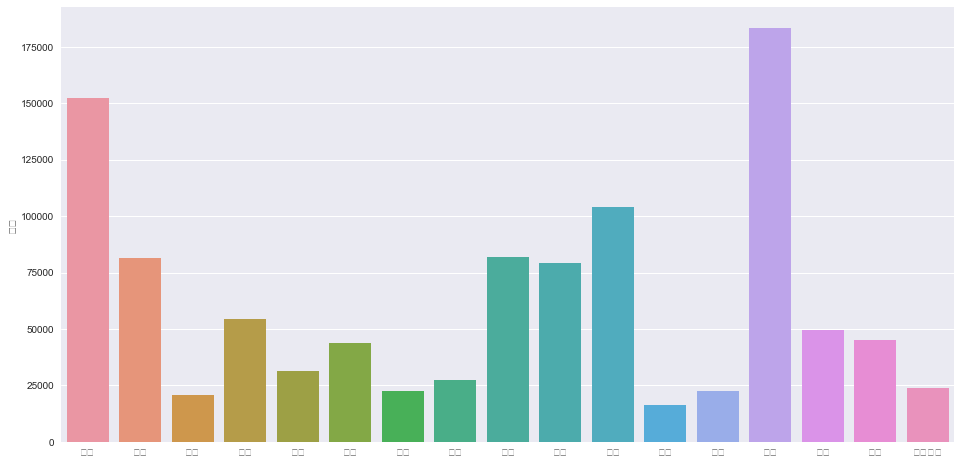

In [59]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import seaborn as sns
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf',size=14)
sns.set(font=myfont.get_name())


plt.figure(figsize=(16,8))
sns.set(style="darkgrid", color_codes=True)
sns.barplot(x=df2.index, y=df2['运入'])
plt.show()

In [75]:
from pyecharts import Bar
style = Style(

    width=1000,
    height=600,
)
attr = df2.index
v1 = df2['运入']
v2 = df2['运出']
bar = Bar("不同城市货物运入和运出量")
bar.add("运入", attr, v1,is_datazoom_show=False, xaxis_interval=0, xaxis_rotate=45,mark_line=['max'])
bar.add("运出", attr, v2, is_datazoom_show=False, xaxis_interval=0, xaxis_rotate=45,mark_line=["max"])
bar.render('1.png')
bar

phantomjs version: 2.1.1

Generating file ...
File saved in C:\Users\liu siyuan\Desktop\物流\大作业\1.png
